# Time-series Analysis
In this notebook we shall explore the USA confirmed cases data set and do a time series analsysis on the same. In order to analyse the data we have to first make sure our data is stationary, by differentiating. We plot the seasonal decomposition, Auto correlation function and Partial auto correlation function to understand the characteristics of our dataset. This information shall be use to determine the ARIMA model for prediction in another notebook.

# Uploading data

In [202]:
from google.colab import files

uploaded = files.upload()#creating file input stream

for fn in uploaded.keys():#getting the input bytes
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))#get name and length of file

# Importing packages

In [203]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import math
import time
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator
plt.style.use('seaborn')
import statsmodels.api as sm
from pandas import DataFrame

# Reading data

In [204]:
conf_cases=pd.read_csv('TS_Conf_dtt.csv')
conf_cases

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1-22-2020,1-23-2020,1-24-2020,1-25-2020,1-26-2020,1-27-2020,1-28-2020,1-29-2020,1-30-2020,1-31-2020,02-01-2020,02-02-2020,02-03-2020,02-04-2020,02-05-2020,02-06-2020,02-07-2020,02-08-2020,02-09-2020,02-10-2020,02-11-2020,02-12-2020,2-13-2020,2-14-2020,2-15-2020,2-16-2020,2-17-2020,2-18-2020,2-19-2020,...,2-15-2021,2-16-2021,2-17-2021,2-18-2021,2-19-2021,2-20-2021,2-21-2021,2-22-2021,2-23-2021,2-24-2021,2-25-2021,2-26-2021,2-27-2021,2-28-2021,03-01-2021,03-02-2021,03-03-2021,03-04-2021,03-05-2021,03-06-2021,03-07-2021,03-08-2021,03-09-2021,03-10-2021,03-11-2021,03-12-2021,3-13-2021,3-14-2021,3-15-2021,3-16-2021,3-17-2021,3-18-2021,3-19-2021,3-20-2021,3-21-2021,3-22-2021,3-23-2021,3-24-2021,3-25-2021,3-26-2021
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6024,6038,6050,6071,6079,6092,6117,6121,6143,6172,6203,6228,6248,6264,6270,6303,6313,6324,6333,6344,6347,6364,6371,6400,6409,6409,6416,6426,6471,6474,6483,6495,6498,6510,6513,6517,6525,6533,6540,6543
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,19136,19176,19267,19324,19361,19392,19433,19461,19554,19635,19670,19698,19714,19732,19758,19790,19856,19873,19890,19915,19935,19942,19962,20012,20044,20072,20091,20103,20210,20227,20263,20287,20317,20329,20347,20361,20354,20395,20417,20423
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2044,2055,2053,2057,2061,2067,2070,2074,2084,2095,2099,2106,2113,2115,2116,2124,2129,2136,2139,2138,2139,2143,2147,2161,2171,2175,2181,2184,2195,2198,2199,2202,2206,2212,2212,2213,2213,2216,2218,2221
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2397,2400,2399,2405,2411,2414,2416,2417,2432,2437,2442,2445,2449,2450,2450,2454,2459,2461,2457,2460,2465,2464,2466,2469,2474,2475,2479,2481,2499,2508,2512,2519,2521,2528,2529,2529,2530,2535,2534,2535
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,5973,5987,5997,6008,6021,6040,6042,6043,6058,6072,6086,6084,6095,6097,6102,6106,6229,6236,6246,6252,6256,6256,6255,6260,6274,6282,6288,6291,6353,6361,6371,6376,6380,6382,6383,6387,6388,6402,6408,6415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,84056039,US,USA,840,56039.0,Teton,Wyoming,US,43.935225,-110.589080,"Teton, Wyoming, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3278,3297,3298,3307,3318,3318,3326,3331,3333,3336,3342,3348,3348,3351,3357,3359,3364,3368,3375,3375,3375,3397,3395,3404,3418,3427,3427,3427,3467,3470,3484,3495,3510,3510,3510,3530,3532,3547,3549,3562
3336,84056041,US,USA,840,56041.0,Uinta,Wyoming,US,41.287818,-110.547578,"Uinta, Wyoming, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1994,2007,2016,2021,2024,2024,2027,2030,2036,2037,2048,2054,2054,2053,2055,2062,2066,2070,2070,2070,2070,2076,2083,2084,2087,2088,2088,2088,2091,2094,2101,2101,2103,2103,2103,2109,2111,2113,2115,2119
3337,84090056,US,USA,840,90056.0,Unassigned,Wyoming,US,0.000000,0.000000,"Unassigned, Wyoming, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3338,84056043,US,USA,840,56043.0,Washakie,Wyoming,US,43.904516,-107.680187,"Washakie, Wyoming, US",0,0,0,0,0,0,0,0,

# Getting date columns

In [205]:
cols=conf_cases.keys()
conf=conf_cases.loc[:, cols[11]:cols[-1]]#dates cols

# Storing total cumilative cases, total new cases and dates to seperate lists

In [206]:
dates=conf.keys()#date keys
cases_tot=[]
cases_new=[]

for i in dates:

  conf_sum=conf[i].sum()# sum of column
  cases_tot.append(conf_sum)#total cases per day
  if(i=='1-22-2020'):
    cases_new.append(conf_sum)
  else:
   cases_new.append(conf[i].sum()-conf[prev].sum())
  prev=i

print("Cumilative cases: ")
print(cases_tot, "\n")
print("Date keys: ")
print(dates, "\n")
print("New cases: ")
print(cases_new, "\n")

Cumilative cases: 
[1, 1, 2, 2, 5, 5, 5, 6, 6, 8, 8, 8, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 16, 16, 16, 16, 16, 16, 17, 17, 25, 32, 55, 75, 108, 185, 238, 404, 520, 595, 783, 1151, 1591, 2224, 2989, 3233, 4691, 6533, 9194, 13689, 20063, 26072, 34898, 46136, 56755, 68837, 86693, 105383, 125013, 143912, 165987, 192301, 224544, 256779, 289066, 321482, 351359, 382740, 413507, 444699, 480640, 515055, 544185, 571440, 598370, 627151, 652591, 682626, 715656, 743588, 769684, 799512, 825429, 854288, 887858, 920185, 950581, 977082, 1000785, 1025362, 1051800, 1081020, 1115946, 1143296, 1167593, 1191678, 1216209, 1240768, 1268180, 1295019, 1320155, 1339022, 1358293, 1381241, 1401649, 1428467, 1453214, 1477373, 1495736, 1518126, 1539133, 1561830, 1587596, 1611252, 1632364, 1652431, 1671104, 1690754, 1709303, 1731625, 1756098, 1779731, 1798718, 1816153, 1837656, 1857501, 1879150, 1904550, 1925710, 1943626, 1961263, 1979647, 2000757, 2023890, 2048756, 2073964, 20929

# Plot daily casees

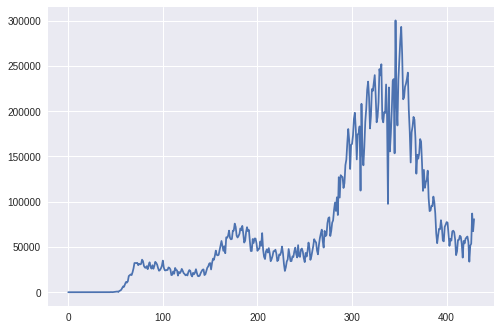

In [207]:
plt.plot(cases_new)

# Plot cumilative cases

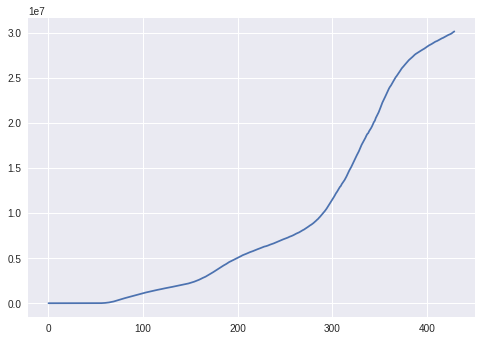

In [208]:
plt.plot(cases_tot)

# Reshaping as arrays

In [209]:
days=np.array([i for i in range (len (dates))]).reshape(-1,1)#day number
cases=np.array(cases_tot).reshape(-1,1)#cases per day
cases_n=np.array(cases_new).reshape(-1,1)#new cases


# Creating dataframes of cumilative cases, new cases, 1st order derivative of cumilative cases and 2nd order derivative of cumilative cases

In [210]:
Cumilative_df= DataFrame(list(zip(dates,cases_tot)),columns=['Datetime','Count'])
New_Cases_df= DataFrame(list(zip(dates,cases_new)),columns=['Datetime','New'])

Diff_1_Cumilative_df=Cumilative_df.copy(deep=True)
Diff_1_Cumilative_df['Count'] = Cumilative_df['Count'] - Cumilative_df['Count'].shift(1)

Diff_2_Cumilative_df=Diff_1_Cumilative_df.copy(deep=True)
Diff_2_Cumilative_df['Count'] = Diff_1_Cumilative_df['Count'] - Diff_1_Cumilative_df['Count'].shift(1)







# Converting dates to date-time format

In [211]:
Cumilative_df['Timestamp'] = pd.to_datetime(Cumilative_df.Datetime,format='%m-%d-%Y') 
Cumilative_df.index = Cumilative_df.Timestamp 
Cumilative_df = Cumilative_df.resample('D').mean()

New_Cases_df['Timestamp'] = pd.to_datetime(New_Cases_df.Datetime,format='%m-%d-%Y') 
New_Cases_df.index = New_Cases_df.Timestamp 
New_Cases_df = New_Cases_df.resample('D').mean()

Diff_1_Cumilative_df['Timestamp'] = pd.to_datetime(Diff_1_Cumilative_df.Datetime,format='%m-%d-%Y') 
Diff_1_Cumilative_df.index = Diff_1_Cumilative_df.Timestamp 
Diff_1_Cumilative_df = Diff_1_Cumilative_df.resample('D').mean()

Diff_2_Cumilative_df['Timestamp'] = pd.to_datetime(Diff_2_Cumilative_df.Datetime,format='%m-%d-%Y') 
Diff_2_Cumilative_df.index = Diff_2_Cumilative_df.Timestamp 
Diff_2_Cumilative_df = Diff_2_Cumilative_df.resample('D').mean()


# Dropping NaN values

In [212]:
Diff_1_Cumilative_df=Diff_1_Cumilative_df.dropna()
Diff_2_Cumilative_df=Diff_2_Cumilative_df.dropna()

# Seasonal decomposition of cumilative cases

The data has a linear trend as well as a seasonality component.

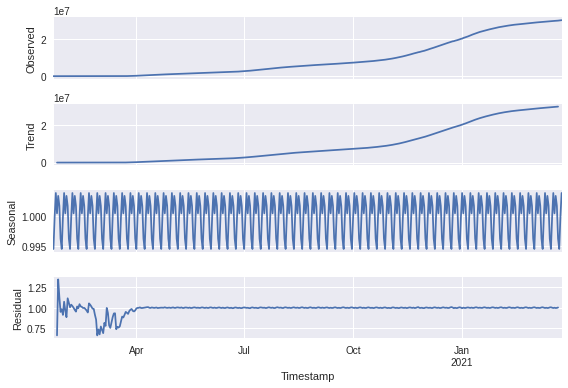

In [213]:
sm.tsa.seasonal_decompose(Cumilative_df.Count, model='multiplictive').plot()
plt.show()

# Seasonal decomposition of daily cases

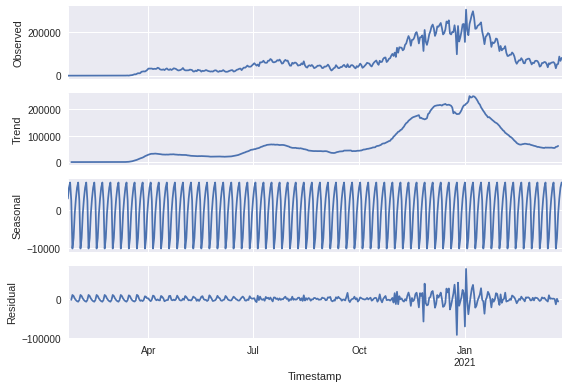

In [214]:
sm.tsa.seasonal_decompose(New_Cases_df.New).plot()
plt.show()

# Plotting the ACF and PACF of the cumilative cases

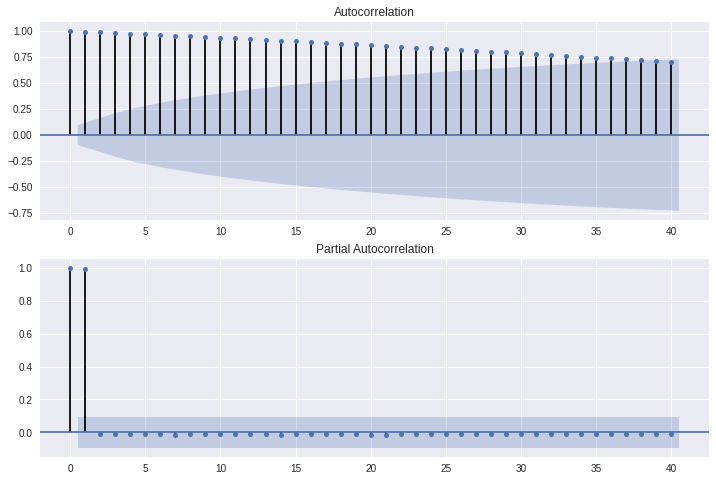

In [215]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(Cumilative_df.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(Cumilative_df, lags=40, ax=ax2)

# Plotting the ACF and PACF of the daily cases

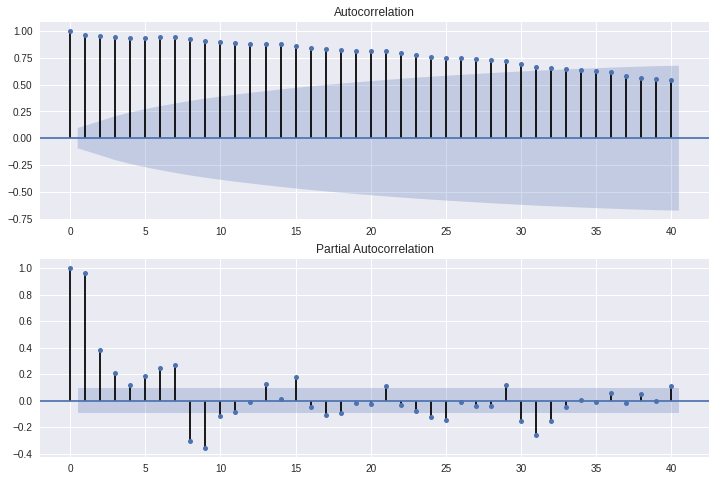

In [216]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(New_Cases_df.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(New_Cases_df, lags=40, ax=ax2)

# Plotting the ACF and PACF of the 1st derivative of cumilative cases

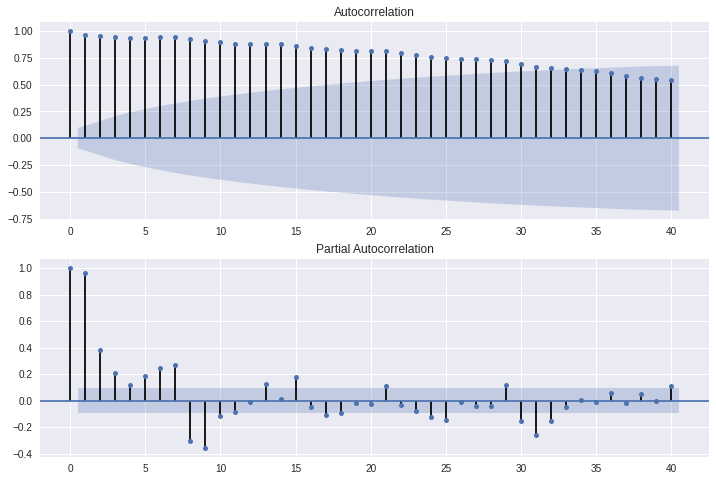

In [217]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(Diff_1_Cumilative_df.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(Diff_1_Cumilative_df, lags=40, ax=ax2)

# Plotting the ACF and PACF of the 2nd derivative of cumilative cases

ACF and PACF plots of the cumilative cases shows that the auto-correlation coefficients gradually decrease as the number of lags increase. This indiates that the time-series in non-stationary and we need to differentiate it further. The ACF plot of the time-series after first order differencing, shows the correlation coefficients decreased gradually which again shows non-stationarity in data implying that we differentiate further. The time-series was differenced for the second time to introduce stationarity. The ACF plot of the second order differenced time-series shows a periodiicity indicating a seasonal series, the sharp significant peak (greater correlation) occurs at lags of 7 days. This pattern strongly supports the existence of seasonality in the time-series. Thus to choose an ARIMA model we need a "d" value of 2.

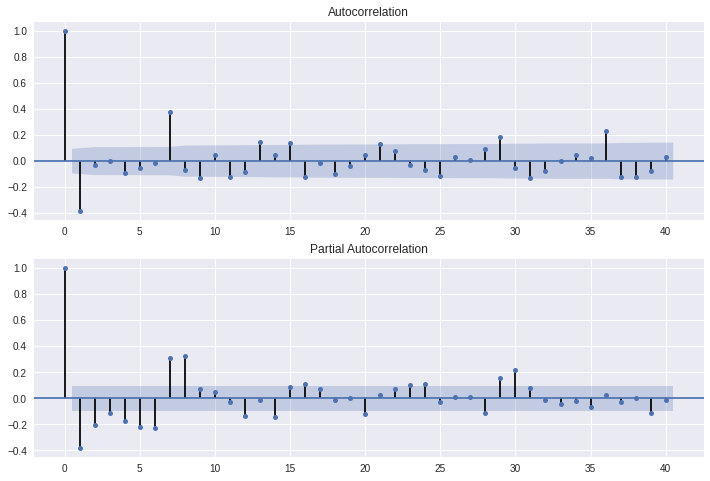

In [218]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(Diff_2_Cumilative_df.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(Diff_2_Cumilative_df, lags=40, ax=ax2)

# Define the Augmented Dickey Fuller function

In [219]:
def adf_test(dframe):
    print ('Results:')
    dftest = sm.tsa.stattools.adfuller(dframe, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

# Check which order of differentiation makes the data stationary

In this case the 2nd order is stationary as the p value is significant for a significance level of 0.05

In [220]:
print("ADF test for Cumilative cases")
adf_test(Cumilative_df.Count)
print("\nADF test for 1st derivative of Cumilative cases")
adf_test(Diff_1_Cumilative_df.Count)
print("\nADF test for 2nd derivative of Cumilative cases")
adf_test(Diff_2_Cumilative_df.Count)

ADF test for Cumilative cases
Results:
Test Statistic                  -0.422088
p-value                          0.906345
#Lags Used                      17.000000
Number of Observations Used    412.000000
Critical Value (1%)             -3.446322
Critical Value (5%)             -2.868581
Critical Value (10%)            -2.570521
dtype: float64

ADF test for 1st derivative of Cumilative cases
Results:
Test Statistic                  -1.667953
p-value                          0.447695
#Lags Used                      17.000000
Number of Observations Used    411.000000
Critical Value (1%)             -3.446361
Critical Value (5%)             -2.868598
Critical Value (10%)            -2.570530
dtype: float64

ADF test for 2nd derivative of Cumilative cases
Results:
Test Statistic                  -4.421741
p-value                          0.000272
#Lags Used                      15.000000
Number of Observations Used    412.000000
Critical Value (1%)             -3.446322
Critical Value (5